In [1]:
import random
import numpy as np
import tensorflow as tf

seed_value= 1111
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)

import warnings
import sys
import os
import pandas as pd
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
# from sklearn.metrics import mean_absolute_percentage_error
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,LSTM, Dense, Flatten, Conv1D, Lambda, Reshape, RepeatVector
from keras.layers.merge import concatenate, multiply,add
from keras import regularizers
from keras.initializers import glorot_uniform
from tqdm import tqdm
from keras import regularizers
from keras.models import load_model
import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import random as python_random
from statsmodels.tsa.stattools import pacf,acf
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

/home/chatta/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chatta/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chatta/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chatta/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

In [2]:
# def MSE(pred,gt):
#     l = pred.shape[1]
#     err = np.zeros((l))
#     err2 = np.zeros((l))
# #     gt = gt[-1440:,:]
#     for i in range(l):
#         err[i] = mse(pred[:,i],gt[:,i])
#         err2[i] = mae(pred[:,i],gt[:,i])
#     return err,err2

def MSE(pred,gt):
    l = pred.shape[0]
    err = np.zeros((l))
    err2 = np.zeros((l))
#     gt = gt[-1440:,:]
#     for i in range(l):
    err[i] = mse(pred,gt)
    err2[i] = mae(pred,gt)
    return err,err2

def metrics(pred,gt):
    l = pred.shape[1]
#     print(l)
    err_mse = np.zeros((l))
    err_mae = np.zeros((l))

    for i in range(l):
        err_mse[i] = mse(pred[:,i],gt[:,i])
        err_mae[i] = mae(pred[:,i],gt[:,i])
        
    return err_mse,err_mae        

In [3]:
d = "/home/chatta/sarima_pemM/theta_preds/traffic/"
# auto_d = "/home/chatta/sarima_pemM/autoencoder_weights/traffic/h9/"
horizon = 1
window_size=50
#for h3 header=None, index_col=None
# theta_preds =np.asarray(pd.read_csv(d+"h9_w12_f1.csv",header=None))
# theta_preds = theta_preds[:12660,:]
# data = np.asarray(pd.read_csv("/home/chatta/logic_rules/data/V_228.csv",header=None))
k_preds=np.asarray(pd.read_csv("/home/chatta/logic_rules/results/pacf_preds/traffic_30_std/h1/preds.csv",header=None))
data = pd.read_csv('/home/chatta/logic_rules/data/traffic_30_with_std.csv',usecols=['avg_flow','pred'])
data= np.asarray(data['avg_flow'])

In [18]:
k_preds.shape

(13493, 1)

In [35]:
# num_test=1440
# train_d = data[:-(2*1440)]
# test_d = data[-(num_test+window_size):,:]
# n_test=1440
# n_data = data.shape[0]
# train_d = data[:-n_test,:]
# test_d =data[-(n_test):,:]
train_d=data[:(int(.8*data.size)+1)]
n_test = int(.1*data.size)


In [191]:
train_d.size

10835

In [12]:
12672-1440

11232

In [14]:
1440/6

240.0

In [163]:
test_d.shape

(1354,)

In [7]:
# p_acf=np.abs(pacf(train_d[:,1],100)[1:])
p_acf=np.abs(pacf(train_d,100)[1:])

In [10]:
a=np.argwhere(np.abs(p_acf)>0.2)
p_acf[a].size

4

In [87]:
a

array([[ 0],
       [ 1],
       [ 2],
       [ 6],
       [14],
       [41],
       [42],
       [43],
       [44],
       [45],
       [48]])

In [218]:
p_temp=[0.96, 0.42, 0.31, 0.11, 0.05, 0.07, 0.25 , 0.05]

In [84]:
p_acf[:10]

array([0.96777593, 0.42310935, 0.31884978, 0.01386057, 0.02718418,
       0.01271628, 0.10609135, 0.09797283, 0.09845965, 0.03700712])

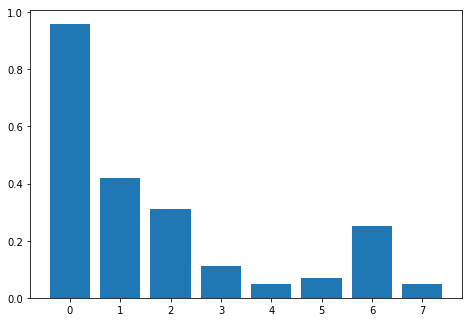

In [223]:
fig=plt.figure()
ax = fig.add_axes([0,0,1,1])
x=np.arange(8)
ax.bar(x,p_temp)
plt.plot()
plt.savefig("hist.png")

In [220]:
savefig("hist.png")

NameError: name 'savefig' is not defined

In [112]:
# def make_input(data,window_size,horizon=1):
#     length=data.shape[0]
#     y = np.zeros([length-window_size+1-horizon,horizon])
#     output=np.zeros([length-window_size+1-horizon,window_size])
#     for i in range(length-window_size-horizon+1):
#         output[i:i+1,:]=data[i:i+window_size]
#         y[i,:]= data[i+window_size:i+window_size+horizon]
#     return output.reshape(output.shape[0],window_size), y

def make_input(data,window_size,horizon=1):
    length=data.shape[0]
    data=np.append(data,0)
    y = np.zeros([length-window_size+1,horizon])
    output=np.zeros([length-window_size+1,window_size])
    for i in range(length-window_size+1):
        output[i:i+1,:]=data[i:i+window_size]
        y[i,:]= data[i+window_size:i+window_size+horizon]
#         print(i)
    return output.reshape(output.shape[0],window_size), y

def make_k_input(data,horizon):
    length = data.shape[0]
    output= np.zeros([length+1-horizon,horizon])
    for i in range(length-window_size-horizon+1):
        output[i:i+1,:]=data[i:i+horizon]
    return output.reshape(output.shape[0],horizon)

def nonov_make_input(data,window_size,horizon=1):
    length=data.shape[0]-window_size
    loop=length//horizon
    extra = length%horizon

    data = np.append(data,np.zeros([horizon-extra]))

    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
        
    output=np.zeros([i_val,window_size])
    y=np.zeros([i_val,horizon])
    for i in range(i_val):
        output[i:i+1,:]=data[i*horizon:(i*horizon)+window_size]
        y[i,:]= data[(i*horizon)+window_size:(i*horizon)+window_size+horizon]
        
    return output.reshape(output.shape[0],window_size), y

def nonov_make_k_input(data,horizon):
    length = data.shape[0]
    loop=length//horizon
    extra = length%horizon
    data_app = np.repeat(data[-1],extra)
    data = np.append(data,data_app)    

    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
    output=np.zeros([i_val,horizon])
    for i in range(i_val):
        output[i:i+1,:]=data[(i*horizon):(i*horizon)+horizon]
    return output.reshape(output.shape[0],horizon)

def logic_rules(data,preds):
    day_sample=48
    window=8
    data=data[2:]
    loop=preds.size//window
    rem=preds.size%window
    out_data=np.zeros((loop,window))
    out_pred=np.zeros((loop,window))
    for i in range(loop):
        out_data[i,:]=data[i*window:i*window+window]
        out_pred[i,:]=preds[i*window:i*window+window]
    rem_data=data[-(48+rem):-48]
    rem_pred=preds[-rem:]
    return out_data,out_pred,rem_data,rem_pred
    
        

In [192]:
horizon=1
window_size=50
final_output=np.zeros((train_d.size-window_size))


p_acf = pacf(train_d,100)[1:]
indexes = np.squeeze(np.argwhere(np.abs(p_acf)>0.2))

weightage=np.ndarray.flatten(np.abs(p_acf[indexes]))
# weightage = weightage/np.sum(np.abs(weightage))
size_of_weightage= weightage.size
input_, label = make_input(data,window_size,horizon)
output =np.zeros([input_.shape[0],horizon])
weight_matrix=np.zeros([1,window_size])
weight_matrix[0,indexes]=weightage
# output = np.append(input_[:,-size_of_weightage:],output,axis=1)   
for z in range(input_.shape[0]):
#         temp=np.zeros{horizon}
#     for j in range(horizon):
#             print(output[z,j:j+size_of_weightage]*weightage)
#         output[z,j+size_of_weightage]= np.sum((output[z,j:j+size_of_weightage]*np.flip(weightage))/np.sum(weightage))
    output[z,0]= (np.sum(input_[z,:]*np.flip(weight_matrix)))/np.sum(weightage)

# output=output[:,size_of_weightage:]
temp=np.squeeze(np.ndarray.flatten(output))
final_output=temp


#-------------logic_rules---------------------


            

        
            
        
        
    

In [181]:
out_data,out_pred,data_rem,pred_rem=logic_rules(data,temp)

In [194]:
indexes


array([ 0,  1,  2, 43])

In [182]:
pred_mean= np.mean(out_pred,axis=1).reshape(out_pred.shape[0],1)
data_mean=np.mean(out_data,axis=1).reshape(out_data.shape[0],1)
pred_std=np.std(out_pred,axis=1)
data_std=np.std(out_data,axis=1)
diff=np.abs(pred_mean-data_mean)
a=np.zeros(0)
f_pred=out_pred
for i in range(out_pred.shape[0]):
    if diff[i]<0.1*data_std[i]:
        a=np.append(a,i)
        f_pred[i] = out_pred[i,:]-pred_mean[i,:]+data_mean[i,:]
# f_rem=pred_rem-np.mean(pred_rem)+np.mean(data_rem)
f_rem=pred_rem
temp1=np.ndarray.flatten(f_pred)
temp1=np.append(temp1,f_rem)

a=a[1:]
    


In [183]:
# temp1, temp2= MSE(test_d[window_size:-2,:],f_pred[-1438:,:])
# [np.sqrt(np.mean(temp1)),np.mean(temp2)]
# temp1, temp2= MSE(test_d,f_pred[-n_test:])
# [temp1,temp2]
mse(temp1[-(n_test):],data[-n_test:])

2.4066233476187575

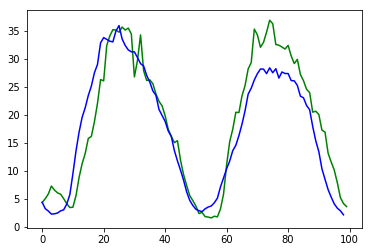

In [188]:
plt.plot(data[:100],'g')

plt.plot(temp[1:100],'b')

In [189]:
temp[1:].size

13493

In [159]:
test_d.shape

(1404,)

In [156]:
f_pred[-n_test+1:(-n_test+50)]
# ,test_d[window_size:window_size+50]]

array([32.37146998, 28.84825968, 29.04972269, 27.7128228 , 26.62098392,
       26.13010863, 26.13527723, 25.56775268, 25.19613108, 24.08640274,
       22.89788621, 22.32548914, 19.7220419 , 17.74922311, 15.21402563,
       13.21365029, 11.01030016,  9.00264612,  7.495157  ,  6.18828824,
        5.72483458,  5.69385612,  4.99850083,  4.63368541,  4.52668786,
        5.01551446,  5.99680929,  7.42699721,  9.78089105, 12.39285899,
       16.54811271, 22.61585965, 27.7689938 , 31.28569582, 32.95757709,
       31.76311809, 29.27031825, 27.16427732, 25.95749263, 26.79090751,
       28.49964803, 29.72864934, 31.06685554, 31.61606098, 31.48937399,
       33.78420843, 35.36295407, 36.10397551, 35.62558706])

In [190]:
np.savetxt('/home/chatta/logic_rules/results/pacf_preds/traffic_30_std/h1/preds_final.csv',temp[1:], fmt='%1.5f',delimiter=',')

In [197]:
n_test

1354

In [196]:
test_d.shape

(1354,)

In [195]:
f_pred.shape

(13493,)

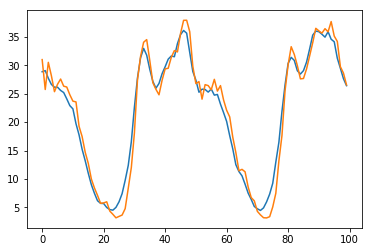

In [201]:
plt.plot(f_pred[-n_test+2:-(n_test-102)])
plt.plot(test_d[:100])

In [110]:
f_pred[-n_test:-(n_test-50)]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])